In [78]:
import numpy as np
import pandas as pd
import torch
import pingouin as pg
from tqdm import tqdm
from nilearn import datasets
from nilearn import plotting
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from sklearn.manifold import TSNE
from contrastive_phenotypes.src.ContModeling.helper_classes import MatData
from contrastive_phenotypes.src.ContModeling.models import PhenoProj
#from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
import xarray as xr
from neuromaps.datasets import fetch_fslr
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
from surfplot import Plot
from statsmodels.robust.scale import Huber
from scipy.stats import trim_mean


In [250]:
mape_mat = np.load('results/final model run 5 : seed 87/recon_mat/mape_mat_run0.npy')

In [251]:
mape_mat.shape

(106, 400, 400)

In [234]:
mape_mat[0]

array([[1.22870979e+01, 1.33925939e+00, 2.21906223e+01, ...,
        3.49378052e+01, 1.78766266e+02, 1.08814980e+02],
       [1.33922553e+00, 5.39136505e+00, 2.34444260e+02, ...,
        2.33111620e+00, 2.54228561e+02, 8.52456951e+00],
       [2.21906223e+01, 2.34444397e+02, 9.00897980e+00, ...,
        1.49531436e+04, 1.60130829e+02, 4.68485336e+01],
       ...,
       [3.49378967e+01, 2.33118796e+00, 1.49531680e+04, ...,
        3.56611862e+01, 2.43959789e+01, 2.41537647e+01],
       [1.78766174e+02, 2.54228928e+02, 1.60130829e+02, ...,
        2.43959656e+01, 1.64980888e+00, 1.60482006e+01],
       [1.08815254e+02, 8.52453804e+00, 4.68484879e+01, ...,
        2.41537704e+01, 1.60481892e+01, 1.32641315e+01]], dtype=float32)

In [252]:
count_greater_than_1 = np.sum(mape_mat > 100)

# Total number of elements in mape_mat
total_elements = mape_mat.size

# Proportion of values greater than 1
proportion_greater_than_1 = count_greater_than_1 / total_elements

# Print the result
print(f"Proportion of values greater than 1: {proportion_greater_than_1:.4f}")

Proportion of values greater than 1: 0.1997


In [258]:
huber_estimator = Huber(maxiter = 5000)

In [278]:
robust_mean_mape_mat = np.empty((400, 400))
# for i in range(400):
#     for j in range(400):
#         robust_mean_mape_mat[i, j], _ = huber_estimator(mape_mat[:, i, j])
# robust_mean_mape_mat = np.empty((400, 400))

#Compute the mean along the 0th dimension for each element
for i in range(400):
    for j in range(400):
        robust_mean_mape_mat[i, j] = np.median(mape_mat[:, i, j])
# robust_mean_mape_mat = np.empty((400, 400))
# for i in range(400):
#     for j in range(400):
#         robust_mean_mape_mat[i, j] = trim_mean(mape_mat[:, i, j], proportiontocut=0.1)


# np.save(f'./abstract_viz/robust_trimmed_mean_mape_mat.npy', robust_trimmed_mean_mape_mat)


Text(-9, 0.02, 'Median MAPE = 37.63')

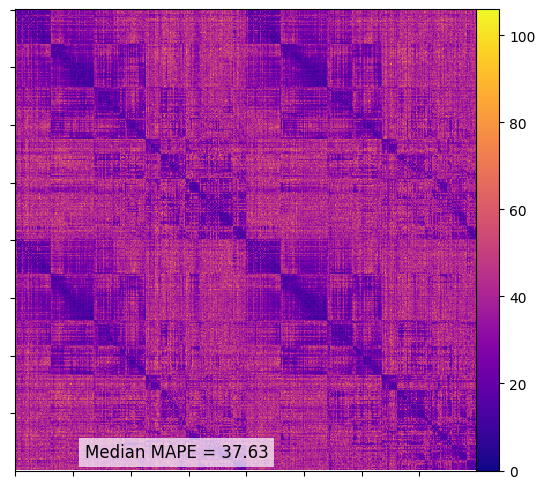

In [279]:
plotting.plot_matrix(robust_mean_mape_mat,
                     grid = False,
                     vmin = 0,
                     vmax = 106,
                     cmap='plasma'
    )
# Calculate the mean correlation value
median_mean_mape = np.median(robust_mean_mape_mat)
# Add text annotation for the mean correlation value
plt.text(-9, 0.02, f'Median MAPE = {median_mean_mape:.2f}', color='black', ha='right', va='bottom', fontsize=12, transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#plt.savefig(f"./abstract_viz/robust_mean_mape_mat.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [150]:
import numpy as np
from nilearn import datasets
from nilearn import plotting
from nilearn import image
from sklearn.preprocessing import LabelEncoder

# Load the Schaefer 400 atlas using nilearn
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400)

# Get the region labels (network labels for Schaefer 400)
atlas_filename = schaefer_atlas
atlas_img = image.load_img(atlas_filename)
atlas_data = atlas_img.get_fdata()

# Load your robust_mean_mape_mat (make sure it's loaded)
# robust_mean_mape_mat = np.load('./abstract_viz/robust_mean_mape_mat.npy')

# Calculate robust mean MAPE for each region, already done in your code

# Now, let's create a network label for each region
# Schaefer 400 gives us a network label for each region. These network labels are in the attribute `regions` of the atlas.
# If `schaefer_atlas` has a file of network labels, load it accordingly
network_labels = schaefer_atlas.region_label  # This should provide the network label for each region

# Now, aggregate robust mean MAPE values by network (mean across regions in the same network)
network_mean_mape = {}
for network_id in np.unique(network_labels):
    regions_in_network = np.where(network_labels == network_id)[0]
    network_mean_mape[network_id] = np.mean([robust_mean_mape_mat[region, region] for region in regions_in_network])

# Sort networks by mean robust MAPE values in descending order
sorted_networks = sorted(network_mean_mape.items(), key=lambda x: x[1], reverse=True)

# Print the top networks most affected by robust mean MAPE
for network_id, mean_mape in sorted_networks[:5]:  # Top 5 most affected networks
    print(f"Network {network_id} has mean robust MAPE of {mean_mape}")


ValueError: File not found: 'maps'

In [119]:
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.surface import load_surf_data, vol_to_surf
from nilearn.plotting import plot_surf_stat_map
import numpy as np

# Load the Schaefer 400 atlas for fsaverage
atlas = fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=1, data_dir=None, base_url=None)
fsaverage = fetch_surf_fsaverage()

# Load parcellation for left hemisphere (adjust path if needed)
parcellation = load_surf_data(fsaverage['sulc_left'])  # Replace with your Schaefer 400 parcellation file

# Expand the 400-region data to vertex-wise data
vertex_data = np.zeros(parcellation.shape)
for region_idx in range(400):
    vertex_data[parcellation == region_idx + 1] = robust_trimmed_mean_mape_mat[region_idx]  # Ensure 1-based indexing

# Plot on the surface
plot_surf_stat_map(
    fsaverage.infl_left,
    stat_map=vertex_data,
    hemi='left',
    bg_map=fsaverage.sulc_left,
    colorbar=True,
    cmap='viridis'
)





ValueError: NumPy boolean array indexing assignment cannot assign 400 input values to the 0 output values where the mask is true

In [246]:
dataset = xr.open_dataset("dataset_400parcels_2.nc")
test_idx = np.load('results/pretraining mat with embeddings 200 and 200 epochs/test_idx.npy')
true_mat = dataset.matrices.isel(subject = test_idx).values

In [247]:
test_idx.shape

(106,)

In [248]:
recon_mat = np.load('results/final model run 5 : seed 87/recon_mat/recon_mat_run0.npy')

In [205]:
32*3+10

106

In [245]:
def compute_batch_elementwise_correlation(true, recon):
    batch_size, rows, cols = true.shape
    correlations = np.zeros((rows, cols))

    flat_true = true.reshape(batch_size, -1)
    flat_recon = recon.reshape(batch_size, -1)
    
    for i in range(rows * cols):
        correlations[i // cols, i % cols] = spearmanr(flat_true[:, i], flat_recon[:, i])[0]
        
    np.fill_diagonal(correlations, 1.0)

    return correlations

In [207]:
batch_1 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_1.npy')
batch_2 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_2.npy')
batch_3 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_3.npy')
batch_4 = np.load('results/pretraining mat with embeddings 200 and 200 epochs/recon_mat/recon_mat_fold2_batch_4.npy')

# Stack them along a new axis (axis=0 means stacking along the first dimension, adding a new dimension)
recon_mat = np.concatenate([batch_1, batch_2, batch_3, batch_4], axis=0)


In [256]:
mat_corr = compute_batch_elementwise_correlation(true_mat, recon_mat)

/tmp/ipykernel_11177/4045408121.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i // cols, i % cols] = spearmanr(flat_true[:, i], flat_recon[:, i])[0]


Text(-14, 0.02, 'Mean r = 0.87')

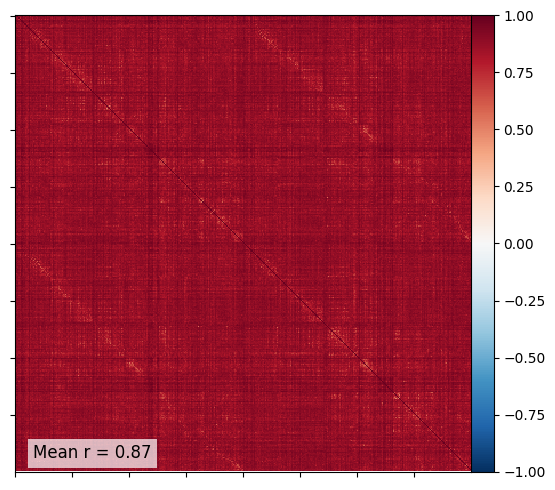

In [266]:
plotting.plot_matrix(mat_corr,
    # title=f"Corr(True, Recon)",
                     grid = False,
                     vmax = 1.,
                     vmin = -1.
    )
# Calculate the mean correlation value
mean_corr = mat_corr.mean()
# Add text annotation for the mean correlation value
plt.text(-14, 0.02, f'Mean r = {mean_corr:.2f}', color='black', ha='right', va='bottom', fontsize=12, transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))